In [1]:
import numpy as np

import unicodedata
import re
import json
import random

import nltk
from nltk.stem.porter import PorterStemmer	
stemmer = PorterStemmer()

from transformers import BertTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModelForCausalLM, AutoTokenizer

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

import pickle

import warnings 
warnings.filterwarnings('ignore')


In [2]:
from Get_Data import GetData

In [3]:
# from huggingface_hub import login
# login()

In [4]:
dialog_question, dialog_answer = GetData()

In [5]:
# Загрузка токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-large", padding_side='left')
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-large")

In [6]:
# Установка токена паддинга
tokenizer.pad_token = tokenizer.eos_token

# Токенизация данных с явным указанием параметра padding
tokenized_question = tokenizer(dialog_question, return_tensors="pt", truncation=True, padding=True)
tokenized_answer = tokenizer(dialog_answer, return_tensors="pt", truncation=True, padding=True)

In [7]:
# Определение класса MyDataset, который наследуется от torch.utils.data.Dataset
class MyDataset(Dataset):
    # Конструктор класса
    def __init__(self, dialog_question, dialog_answer, tokenizer):
        # Сохранение переданных данных в атрибуты класса
        self.dialog_question = dialog_question
        self.dialog_answer = dialog_answer
        self.tokenizer = tokenizer

    # Метод, возвращающий длину датасета
    def __len__(self):
        return len(self.dialog_question)

    # Метод, возвращающий элемент датасета по указанному индексу
    def __getitem__(self, idx):
        # Получение elrian_input и leonard_target для текущего индекса
        input = self.dialog_question[idx]
        target = self.dialog_answer[idx]

        # Токенизация elrian_input с добавлением токенов паддинга и обрезкой
        tokenized_data = self.tokenizer(input, return_tensors="pt", padding=True, truncation=True)

        # Создание меток (labels) путем сдвига входной последовательности
        labels = self.tokenizer(target, return_tensors="pt", padding=True, truncation=True)["input_ids"]

         # Возвращение словаря с ключами "input_ids" и "labels", сжатых до размерности 1
        return {
            "input_ids": tokenized_data["input_ids"].squeeze(),
            "labels": labels.squeeze()
        }


In [8]:
# Создание экземпляра датасета и DataLoader
my_dataset = MyDataset(dialog_question, dialog_answer, tokenizer)
train_data_loader = DataLoader(my_dataset, batch_size=16, shuffle=True, collate_fn=lambda batch: batch)

In [9]:
# Подготовка модели для дообучения
# тут добавляю новый слой который планирую дообучать
# в связи с малым датасетом, обуение до слоя шло очень плохо.
# код оставлю, что бы показать, то как это делал
# new_layer = torch.nn.Linear(model.config.hidden_size, len(tokenizer.get_vocab()))
# model.lm_head = new_layer

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# !!!! Тут хардкожу CPU, т.к. у меня не хватате памяти для обучения на видеокарте
device = 'cpu'
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50257, bias=False)
)

In [11]:
# Определение оптимизатора и функции потерь
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [16]:
# всего обучал на большем количестве эпох, перезапуская после каждой итерации
num_epochs = 30

In [13]:
losses = []

In [14]:
# Тут загружаю историю loss для формирования графика
# Использую в случаях, если обучение разбито на несколько сессий
# with open('./DZ1model/DialogGPT/losses.pkl', 'rb') as file:
#     losses = pickle.load(file)

In [17]:
# Цикл по эпохам обучения
for epoch in range(num_epochs):
    # Перевод модели в режим обучения
    model.train()
    # Обнуление суммарной потери на текущей эпохе
    total_loss = 0

    # Итерация по батчам в DataLoader с отображением прогресса
    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch + 1}"):

        # Извлечение входных данных (input_ids) и меток (labels) из текущего батча
        inputs = batch[0]["input_ids"].to(device)
        labels = batch[0]["labels"].to(device)

        # Выравнивание длины последовательностей до минимальной длины в текущем батче
        min_length = min(inputs.size(0), labels.size(0))
        inputs = inputs[:min_length]
        labels = labels[:min_length]

        # Обнуление градиентов перед обратным распространением
        optimizer.zero_grad()

        # Получение выходов модели и вычисление потери
        outputs = model(inputs, labels=labels.flatten())
        loss = outputs.loss
        total_loss += loss.item()


        # Обратное распространение градиентов
        loss.backward()

        # Обновление весов модели с использованием оптимизатора
        optimizer.step()

    # Вычисление средней потери на текущей эпохе и вывод информации
    average_loss = total_loss / len(train_data_loader)
    losses.append(average_loss)
    print(f"Epoch {epoch + 1}, Average Loss: {average_loss}")


Epoch 1: 100%|██████████| 233/233 [13:56<00:00,  3.59s/it]


Epoch 1, Average Loss: 5.782779449045402


Epoch 2: 100%|██████████| 233/233 [14:09<00:00,  3.65s/it]


Epoch 2, Average Loss: 5.584128104054365


Epoch 3: 100%|██████████| 233/233 [14:05<00:00,  3.63s/it]


Epoch 3, Average Loss: 5.597520513084313


Epoch 4: 100%|██████████| 233/233 [14:02<00:00,  3.62s/it]


Epoch 4, Average Loss: 5.369498584403501


Epoch 5: 100%|██████████| 233/233 [14:07<00:00,  3.64s/it]


Epoch 5, Average Loss: 5.228711523211565


Epoch 6: 100%|██████████| 233/233 [14:10<00:00,  3.65s/it]


Epoch 6, Average Loss: 4.989319324493408


Epoch 7: 100%|██████████| 233/233 [14:09<00:00,  3.65s/it]


Epoch 7, Average Loss: 5.210636873613612


Epoch 8: 100%|██████████| 233/233 [14:12<00:00,  3.66s/it]


Epoch 8, Average Loss: 5.2628019925350795


Epoch 9: 100%|██████████| 233/233 [14:12<00:00,  3.66s/it]


Epoch 9, Average Loss: 5.162152471460498


Epoch 10: 100%|██████████| 233/233 [14:08<00:00,  3.64s/it]


Epoch 10, Average Loss: 5.298331029425364


Epoch 11: 100%|██████████| 233/233 [14:02<00:00,  3.62s/it]


Epoch 11, Average Loss: 4.996688267703732


Epoch 12: 100%|██████████| 233/233 [14:08<00:00,  3.64s/it]


Epoch 12, Average Loss: 5.156979842247369


Epoch 13: 100%|██████████| 233/233 [14:03<00:00,  3.62s/it]


Epoch 13, Average Loss: 4.9024735121256295


Epoch 14: 100%|██████████| 233/233 [14:16<00:00,  3.68s/it]


Epoch 14, Average Loss: 5.101719230029716


Epoch 15: 100%|██████████| 233/233 [14:11<00:00,  3.65s/it]


Epoch 15, Average Loss: 4.929848856680383


Epoch 16: 100%|██████████| 233/233 [14:08<00:00,  3.64s/it]


Epoch 16, Average Loss: 4.802374737073423


Epoch 17: 100%|██████████| 233/233 [14:09<00:00,  3.65s/it]


Epoch 17, Average Loss: 4.877981944145563


Epoch 18: 100%|██████████| 233/233 [14:08<00:00,  3.64s/it]


Epoch 18, Average Loss: 4.673113635425404


Epoch 19: 100%|██████████| 233/233 [14:06<00:00,  3.63s/it]


Epoch 19, Average Loss: 4.8510186881978115


Epoch 20: 100%|██████████| 233/233 [14:08<00:00,  3.64s/it]


Epoch 20, Average Loss: 4.504130705743388


Epoch 21: 100%|██████████| 233/233 [14:06<00:00,  3.63s/it]


Epoch 21, Average Loss: 4.85905265449966


Epoch 22: 100%|██████████| 233/233 [14:08<00:00,  3.64s/it]


Epoch 22, Average Loss: 4.774344498507455


Epoch 23: 100%|██████████| 233/233 [14:08<00:00,  3.64s/it]


Epoch 23, Average Loss: 4.6385244021088265


Epoch 24: 100%|██████████| 233/233 [14:04<00:00,  3.63s/it]


Epoch 24, Average Loss: 4.6162575892624425


Epoch 25: 100%|██████████| 233/233 [14:11<00:00,  3.65s/it]


Epoch 25, Average Loss: 4.4232249584832415


Epoch 26: 100%|██████████| 233/233 [14:12<00:00,  3.66s/it]


Epoch 26, Average Loss: 4.317639903193379


Epoch 27: 100%|██████████| 233/233 [14:07<00:00,  3.64s/it]


Epoch 27, Average Loss: 4.250591804541232


Epoch 28: 100%|██████████| 233/233 [14:14<00:00,  3.67s/it]


Epoch 28, Average Loss: 4.367561268959946


Epoch 29: 100%|██████████| 233/233 [14:12<00:00,  3.66s/it]


Epoch 29, Average Loss: 4.264936363364494


Epoch 30: 100%|██████████| 233/233 [14:10<00:00,  3.65s/it]

Epoch 30, Average Loss: 4.178282370383136


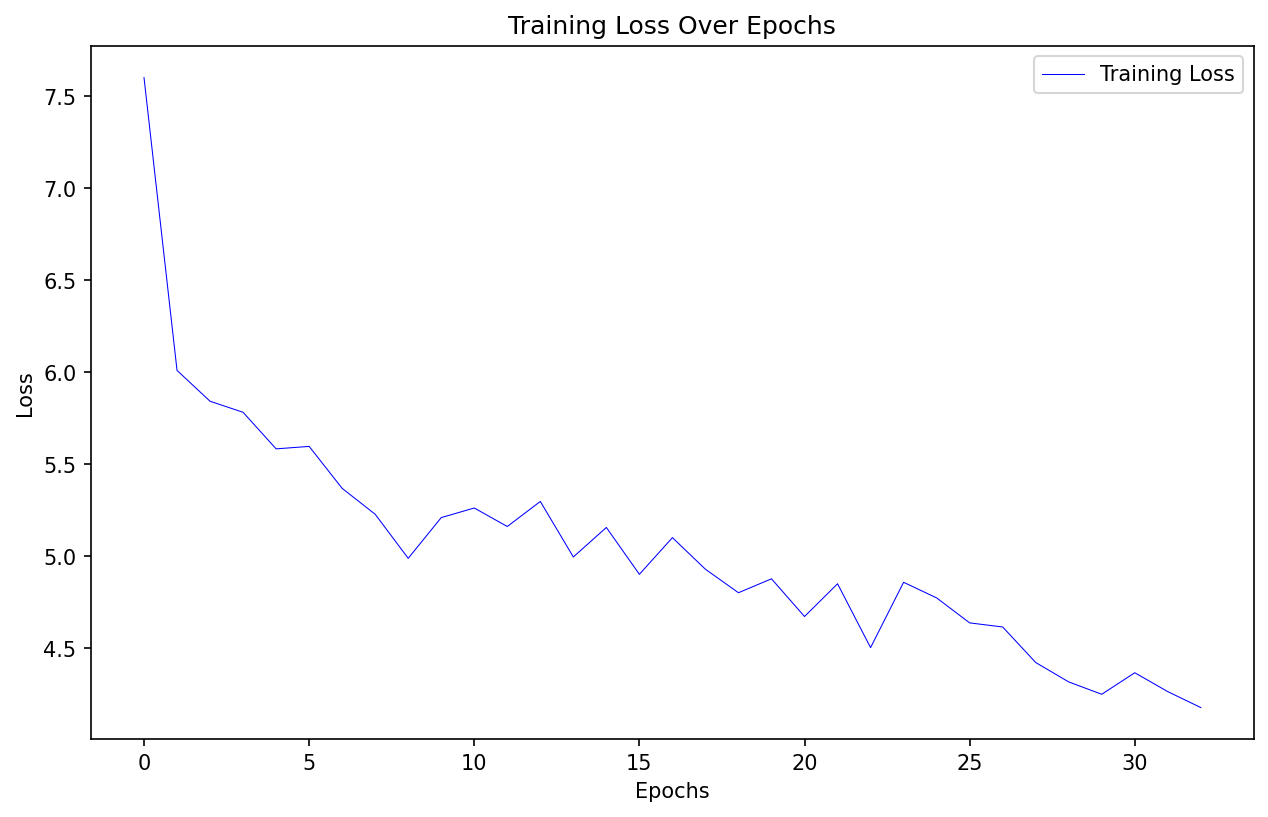

In [21]:
plt.figure(figsize=(10, 6), dpi=150)

plt.plot(range(0, len(losses)), losses, linestyle='-', color='b', linewidth=0.5, marker='', label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.show()

In [19]:
with open('./DZ2model/DialogGPT_2_ver2/losses.pkl', 'wb') as file:
    pickle.dump(losses, file)

In [20]:
model.save_pretrained("./DZ2model/DialogGPT_2_ver2")
tokenizer.save_pretrained("./DZ2model/DialogGPT_2_ver2")

('./DZ2model/DialogGPT_2_ver2/tokenizer_config.json',
 './DZ2model/DialogGPT_2_ver2/special_tokens_map.json',
 './DZ2model/DialogGPT_2_ver2/vocab.json',
 './DZ2model/DialogGPT_2_ver2/merges.txt',
 './DZ2model/DialogGPT_2_ver2/added_tokens.json',
 './DZ2model/DialogGPT_2_ver2/tokenizer.json')